# **Proyecto de aprendizaje profundo**

Equipo 11:

*   Ana Vivar Rojas    - A01798128
*   Citlali Daniela Martínez Maya - A01747804

Grupo: 302

Profesora: Andrea Torres Calderón

Fecha: 27 de noviembre de 2023


## **Introducción**

La clasificación automática es un proceso en donde se ejecutan distintas acciones por medio de un sistema, esto con el fin de ordenar elementos en clases o categorías. Este tipo de aprendizaje profundo implica poder entrenar un modelo que permita aprender patrones o reconocer características de los datos para así poder categorizarlos en una clase.

Las redes neuronales convolucionales y la clasificación automática de imágenes están ampliamente relacionadas, ya que este tipo de redes realiza la extracción de características de las imágenes de una forma más eficiente para después pasarlas por una red neuronal densa para realizar la clasificación de las imágenes. Estas redes neuronales convolucionales (CNN) son arquitecturas de las redes neuronales artificiales profundas. Las CNN tienen una gran eficiencia al trabajar con imágenes, ya que aprenden patrones y características específicas de los datos.

El objetivo de este proyecto es utilizar la clasificación automática para poder realizar modelos con redes convolucionales que puedan clasificar los diferentes tipos de prendas que se encuentran en la base de datos de Fashion MNIST de la librería de Tensorflow. Como ya se mencionó anteriormente, las redes convolucionales realizan un buen trabajo en problemas multiclase con imágenes, por esa razón la arquitectura de nuestro modelo utilizará las capas convolucionales que aplican filtros de extracción de características, además de capas pooling que reducen la dimensionalidad y capas totalmente conectadas.

La base de datos que se usará en el proyecto es Fashion MNIST, la cual presenta un conjunto de imágenes, las cuales contienen algún tipo de ropa. La base de datos cuenta con 70,000 imágenes que se encuentran como arreglos de NumPy en escala de grises (1 canal) de 28x28 pixeles que tienen valores entre 0 y 255.  Además, la ropa se divide en 10 clases que van del 0 a 9, en donde se encuentra cada tipo de ropa: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag y Ankle boot.

Para la división de los conjuntos de entrenamiento y prueba, utilizamos la división de los conjuntos que está predeterminada al cargar la base de datos, de esta forma se obtienen 60,000 imágenes en el conjunto de entrenamiento y 10,000 para el de prueba. Después, para obtener el set de validación, quitamos 12,000 imágenes al conjunto de entrenamiento que es equivalente al 20% para pasarlas al set de validación. Por lo tanto, los conjuntos quedaron con la siguiente cantidad de imágenes:

*   Entrenamiento: 48,000
*   Validación: 12,000
*   Prueba: 10,000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importación de las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Descarga y división del conjunto de datos

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


### Exploración de los datos

In [ ]:
# Tamaño del conjunto de datos de entrenamiento
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [ ]:
60000*0.2

12000.0

In [ ]:
# Reservamos 12,000 samples para validación
X_val = X_train[-12000:]
y_val = y_train[-12000:]
X_train = X_train[:-12000]
y_train = y_train[:-12000]

In [ ]:
# Tamaño del conjunto de datos de entrenamiento
print(X_train.shape)
print(y_train.shape)

(48000, 28, 28)
(48000,)


In [ ]:
# Tamaño del conjunto de datos de validación
print(X_val.shape)
print(y_val.shape)

(12000, 28, 28)
(12000,)


In [ ]:
# Tamaño del conjunto de datos de prueba
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [ ]:
print('Valor mínimo: ', X_train.min())
print('Valor máximo: ', X_train.max())

Valor mínimo:  0
Valor máximo:  255


### Normalización de los datos

In [ ]:
# Reescalar imágenes
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
print('Valor mínimo: ', X_train.min())
print('Valor máximo: ', X_train.max())

Valor mínimo:  0.0
Valor máximo:  1.0


### Visualización del conjunto de entrenamiento

In [ ]:
def visualize_dataset(n,x,y):
    plt.figure(figsize=(10,10))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.get_cmap('gray'))
        plt.xlabel(y[i])
    plt.show()

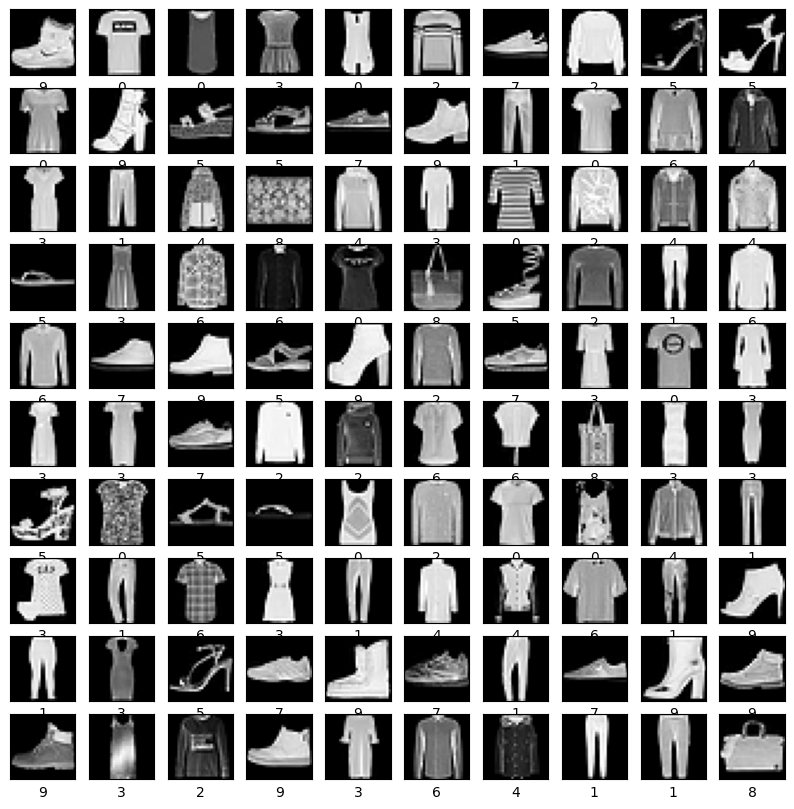

In [ ]:
visualize_dataset(10, X_train, y_train)

In [ ]:
def visualize_labels(y,visualize=False):
    unique, counts = np.unique(y, return_counts=True) # Encuentra los elementos únicos de un array
    print('Clases: ', unique)
    print('Número de instancias por clase', counts)

    if visualize == True:
        plt.figure(figsize=(11,5))
        plt.bar(unique,counts, color = (0.3,0.1,0.4,0.6))
        plt.xlabel('Clases')
        plt.ylabel('Frecuencia')
        plt.xticks(unique)

        for i, v in enumerate(counts):
            plt.text(i-0.25, v+10, str(v), color = 'blue')
        plt.show()

Clases:  [0 1 2 3 4 5 6 7 8 9]
Número de instancias por clase [4764 4794 4768 4796 4785 4806 4851 4820 4820 4796]


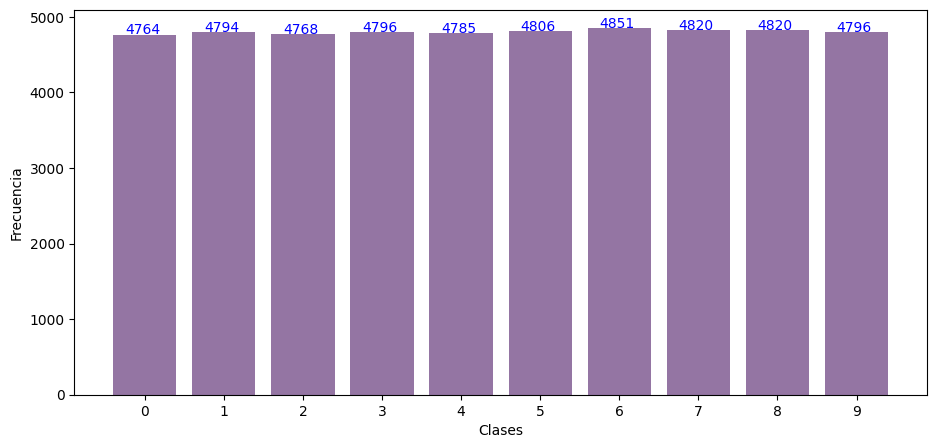

In [ ]:
# Número de imágenes por cada clase
visualize_labels(y_train, True)

## **Modelo 1**

Para diseñar la arquitectura del modelo 1, nos basamos en los conocimientos aprendidos en clase y en algunas de las arquitecturas vistas en páginas como Kaggle y en foros de discusión como stackoverflow. Nuestro modelo se compone de 5 bloques de capas, los primeros dos bloques realizan la extracción de características, el tercer bloque hace la conversión del mapa de características para que las capas densas puedan analizar la información, el cuarto y quinto bloque hacen la clasificación.

El primer bloque de capas de nuestro modelo 1 se compone de una capa de convolución de 128 filtros y un kernel de 3x3 con un stride de uno; otra de Batch normalization con los parámetros que tiene por default; una función de activación ReLU, una capa de Max Pooling con un kernel de 2x2, y por último aplicamos un Dropout con un 40% antes del segundo bloque de capas para evitar que se realice overfitting y que la red generalice mejor los datos. El segundo bloque de capas es igual al primer bloque, pero en la capa de convolución utilizamos 32 filtros con un kernel de 3x3 y un stride de 1.

Después, aplicamos una capa Flatten al mapa de características para luego poner una capa densa de 50 neuronas seguida de una capa de normalización (Batch normalization) y una función de activación ReLU. Finalmente, tenemos un Dropout de 0.4 y una capa densa de 10 neuronas con una función de activación SoftMax en nuestra capa de salida.


In [ ]:
from keras.layers import Conv2D, Dropout
from keras.layers import MaxPool2D, BatchNormalization, Activation

In [ ]:
model = Sequential()
model.add(Conv2D(128,3,1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))

model.add(Conv2D(32,3,1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(10, activation ='softmax'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) #optimizer, loss, metrics

### **Cálculo de los parámetros entrenables**

Conocer el número de parámetros que tiene nuestra red neuronal convolucional es importante, ya que de esta manera podemos conocer cuánta memoria ocupa nuestro modelo y aumentar la rapidez del entrenamiento del modelo, ya que esta depende del número de parámetros con los que cuenta nuestro modelo.

Para el cálculo de los parámetros entrenables del modelo 1, primero necesitamos saber la forma que tienen las salidas de las capas, para ello necesitamos las siguientes fórmulas:

<p>&nbsp;</p>

##### *Salida de la capa de convolución*

* Formula 1 : $\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1}$

* Formula 2 :  $\mathbf{H_{out} = \frac{H_{in} - K + 2P}{S} + 1}$  

Donde la dimensión de una imagen es $W_{in} \times H_{in}$.
Las dimensiones del filtro $K \times K$, stride $S$ y padding $P$.

<p>&nbsp;</p>

##### *Salida de la capa de Maxpooling*

* Formula 3 : $\mathbf{ O_{maxP} = \frac{Input - K}{S}+1}$

Donde $K$ es el tamaño del filter/kernel, y $S$ es el stride.
<p>&nbsp;</p>

##### *Salida de la capa Flatten*

* Formula 4 : $\mathbf{ O_{flatten} = W_{p} \cdot H_{p} \cdot F_{p}}$

Donde $W_{p}$ es el ancho de la capa anterior, $H_{p}$ es la altura de la capa anterior y $F_{p}$ es el número de filtros de la capa anterior.

<p>&nbsp;</p>

Después de obtener el tamaño de la salida de las capas, para el cálculo de los parámetros se utilizan las siguientes fórmulas:

<p>&nbsp;</p>

##### *Parámetros de la capa de convolución*

* Formula 5 : $\mathbf{P_{cov2d}=[(K \cdot K \cdot F_p)+1]F}$

Donde $K$ es el tamaño del kernel, $F_p$ es el número de filtros en la capa anterior y $F$ es el número de filtros en la capa actual. El $1$ hace referencia al bias de la capa.

<p>&nbsp;</p>

##### *Parámetros de la capa de BatchNormalization*

* Formula 6 : $\mathbf{P_{BN}=4F_p}$

Donde $F_p$ es el número de filtros en la capa anterior que se multiplica por 4 debido a que la capa de BatchNormalization calcula 4 parámetros por cada filtro de la capa anterior de forma predeterminada.

<p>&nbsp;</p>

##### *Parámetros de la capa de Pooling*

No hay parámetros entrenables en la capa de Pooling.

<p>&nbsp;</p>

##### *Parámetros de la capa de Densa*

* Formula 7 : $\mathbf{P_{Dense}= (N_{in} \cdot N_{out}) + N_{out}}$

Donde $N_{in}$ son el número de parámetros que recibe la capa a la entrada y $N_{out}$ son el número de neuronas de la capa.

<p>&nbsp;</p>

#### Cálculos del primer bloque:

1.   Capa de convolución con 128 filtros, $K=3$, $S=1$ y $P=0$. Donde el tamaño del tensor tiene de ancho $W_{in}=13$ y de altura $H_{in}=13$. Usando las fórmulas 1 y 2 se obtiene:

    $W_{out} = \frac{13 - 3 + 2(0)}{1} + 1= 26 \qquad y \qquad H_{out} = \frac{13 - 3 + 2(0)}{1} + 1= 26$

    Por lo tanto la salida de la capa de convolución es: (None, 26, 26, 128)

    Usando la fórmula 5 obtenemos el siguiente número de parámetros:

    ${P_{cov2d}=[(3 \cdot 3 \cdot 1) + 1] \cdot 128} = 1280$


2.   Para la capa de Batch Normalization no se realiza ninguna reducción en la salida, pero el número de parámetros es:

    $P_{BN}=4(128) = 512$

3.  En la capa de activación la salida se mantiene igual que la capa anterior y no hay parámetros.

4. En la capa de MaxPooling se tiene que $K=2$, $S=2$ y un $Input = 26$; esta capa no tiene parámetros. Usando la fórmula 3 se obtiene:

    $O_{maxP} = \frac{26 - 2}{2}+1 = 13$

    Por lo tanto la salida de la capa de pooling es: (None, 13, 13, 128)

5. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del segundo bloque:

1.   Capa de convolución con 32 filtros, $K=3$, $S=1$ y $P=0$. Donde el tamaño de las imágenes es de 28 x 28 ($W_{in}=28$ y $H_{in}=28$). Usando las fórmulas 1 y 2 se obtiene:

    $W_{out} = \frac{28 - 3 + 2(0)}{1} + 1= 11 \qquad y \qquad H_{out} = \frac{28 - 3 + 2(0)}{1} + 1= 11$

    Por lo tanto la salida de la capa de convolución es: (None, 11, 11, 128)

    Usando la fórmula 5 obtenemos el siguiente número de parámetros:

    ${P_{cov2d}=[(3 \cdot 3 \cdot 128) + 1] \cdot 32} = 36896$

2.   Para la capa de Batch Normalization no se realiza ninguna reducción en la salida, pero el número de parámetros se calcula con la fórmula 6 donde $F_p=32$:

    $P_{BN}=4(32) = 128$

3.  En la capa de activación la salida se mantiene igual que la capa anterior y no hay parámetros entrenables.

4. En la capa de MaxPooling se tiene que $K=2$, $S=2$ y un $Input = 11$; en esta capa no hay parámetros. Usando la fórmula 3 se obtiene:

    $O_{maxP} = \frac{11 - 2}{2}+1 = 5.5$

    El $5.5$ se redondea hacia abajo dando como resultado $5$,por lo tanto la salida de la capa de pooling es: (None, 5, 5, 32)

5. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del tercer bloque:

1. La capa Flatten no tiene parámetros entrenables y para su salida sólo se multiplican los valores del tensor de la capa anterior sin contar None (5, 5, 32), usando la fórmula 4 donde $W_{p} = 5$, $H_p=5$ y $F_p=32$:

  $ O_{flatten} = 5 \cdot 5 \cdot 32 = 800$

  De este modo, la salida de esta capa es: (None, 800)

<p>&nbsp;</p>

#### Cálculos del cuarto bloque:

A partir de este bloque las salidas de las capas son el número de neuronas con las que cuenta esa capa.

1. Como la capa densa cuenta con 50 neurona, su salida es: (None, 50). Para el cálculo de los parámetros se utiliza la fórmula 7 con $N_{in}=800$ y $N_{out}=50$:

  $P_{Dense}= (800 \cdot 50) + 50= 40050$

2. En la capa de BatchNormalization se mantiene la salida de la capa anterior y se tiene que el número de parámetros, de acuerdo a la fórmula 6 donde ahora se toma $F_p$ como el número de neuronas de la capa anterior siendo $F_p=50$, es:

  $P_{BN}=4(50)=200$

3. En la capa de la función de activación se mantiene la misma salida que la capa anterior y no se tienen parámetros entrenables.

4. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del quinto bloque:

1. Para la capa de salida, se tienen 10 neuronas por lo tanto su salida es (None, 10). El número de parámetros, de acuerdo a la fórmula 7 donde $N_{in}=50$ y $N_{out}=10$, es:

  $P_{Dense}= (50 \cdot 10) + 10 = 510$

<p>&nbsp;</p>

#### Número total de parámetros del modelo 1

Para conocer el número total de parámetros sólo se suman los parámetros de todas las capas.

  $T_{parameters}= 1280+512+36896+128+40050+200+510=79576$

In [ ]:
model.build((None, 28, 28, 1))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 batch_normalization_41 (Ba  (None, 26, 26, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_40 (Activation)  (None, 26, 26, 128)       0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 13, 13, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 13, 13, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 11, 32)      

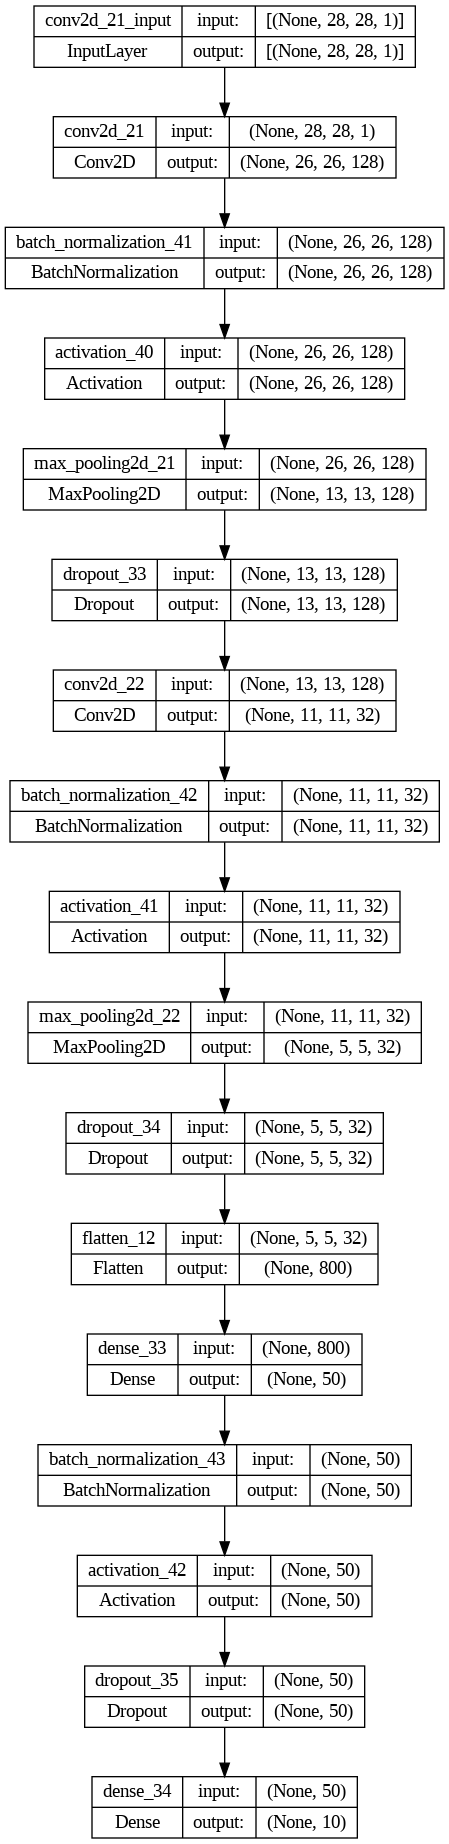

In [ ]:
plot_model(model, show_shapes=True)

### Entrenamiento del modelo 1

In [ ]:
# "/content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo1_1.h5" con kernel_regularizer

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5,  mode='min',  verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo1_1sinreg.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks=[es, checkpoint], epochs=150,verbose=1)

Epoch 1/150
1498/1500 [============================>.] - ETA: 0s - loss: 0.7447 - accuracy: 0.7432
Epoch 1: val_loss improved from inf to 0.42821, saving model to /content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo1_1sinreg.h5
1500/1500 [==============================] - 14s 8ms/step - loss: 0.7444 - accuracy: 0.7432 - val_loss: 0.4282 - val_accuracy: 0.8431
Epoch 2/150
1495/1500 [============================>.] - ETA: 0s - loss: 0.5113 - accuracy: 0.8185
Epoch 2: val_loss improved from 0.42821 to 0.36869, saving model to /content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo1_1sinreg.h5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.5114 - accuracy: 0.8184 - val_loss: 0.3687 - val_accuracy: 0.8680
Epoch 3/150
1494/1500 [============================>.] - ETA: 0s - loss: 0.4655 - accuracy: 0.8336
Epoch 3: val_loss improved from 0.36869 to 0.33333, saving model to

### Evaluación del modelo 1

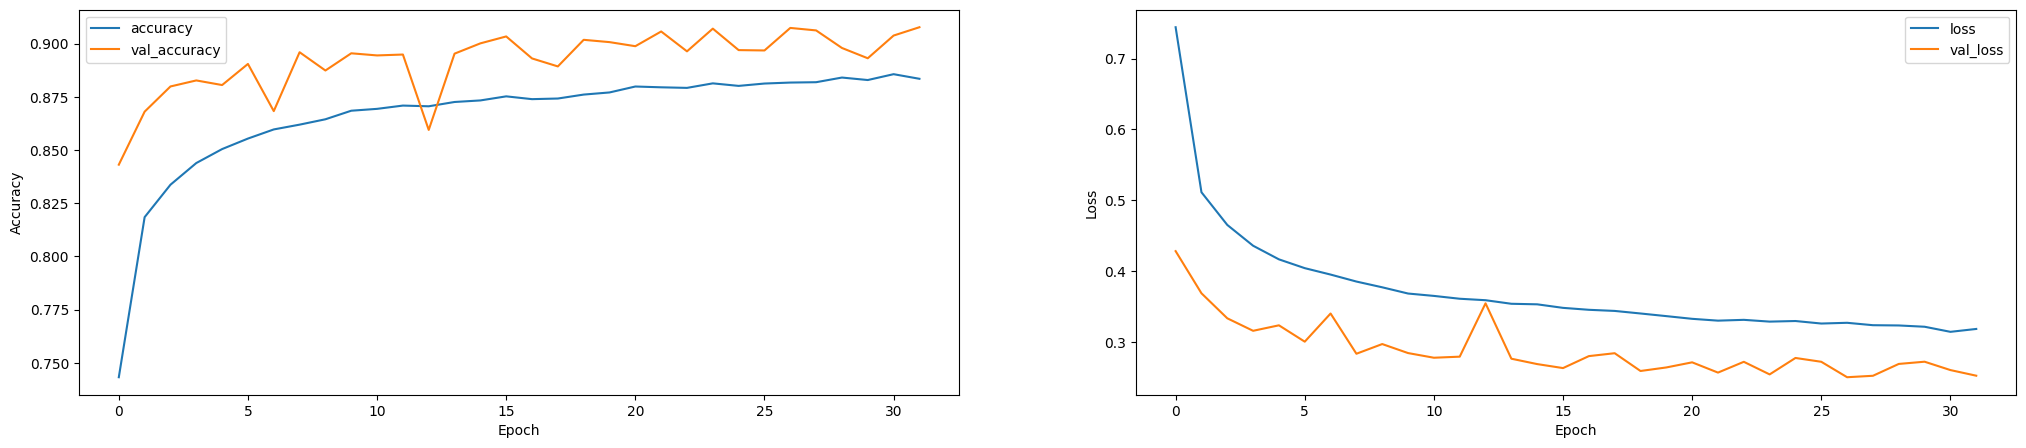

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(25, 5))
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
plt.show()

In [ ]:
val_loss1, val_acc1 = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation accuracy: {val_acc1:.2f}')
print(f'Validation loss: {val_loss1:.2f}')

Validation accuracy: 0.91
Validation loss: 0.25


En la gráfica donde se presenta el acuracy, se observa que validation_accuracy esta arriba de training_accuracy, por lo que podremos decir que en validation obtenemos mayor precisión comparado al entrenamiento. El accuracy sobrepasa un poco más de 0.90, por lo cual es aceptable. La curva de validación con la de training no se encuentran demasiado separadas. Se observan algunos picos dentro de la recta debido a que en algunos momentos bajaba el accuracy durante la carga del modelo, sin embargo lo restauró de forma rápida.

En la gráfica de pérdida, a pesar de que las curvas no están completamente juntas, no hay una gran diferencia, e incluso la parte de validación tiene menores pérdidas, llegando a un aproximado de sólo 0.25. Aunque podríamos llegar a pensar que hay una pequeña presencia de overfitting, está bien para un conjunto de entrenamiento en el que hay bastantes datos, ya que en el conjunto de prueba este modelo será más robusto.


## **Modelo 2**
De la misma manera en el modelo dos se utilizaron los conocimientos aprendidos en clase y algunos tipos de arquitecturas que se encuentran en foros de discusión o páginas de Kaggle. Es necesario mencionar que para poder dejar estos modelos, hicimos un sinfín de pruebas quitando funciones, probando más neuronas e incluso otros métodos. Este segundo modelo se compone de 6 bloques de capas, los primeros dos bloques realizan la extracción de características, el tercer bloque hace la conversión del mapa de características para que las capas densas puedan analizar la información, el cuarto, quinto y sexto bloque hacen la clasificación.

En este caso, el primer bloque de las capas del segundo modelo  se compone de una capa de convolución de 128 filtros y un kernel de 3x3 con un stride de uno; además contiene una capa de Batch normalization con los parámetros que tiene por default; una función de activación ReLU y por último una capa de Max Pooling con un kernel de 2x2.   

El segundo bloque se construyó de manera similar al primero, sin embargo algunos valores varían.En la capa de convolución ahora se encuentran 64 filtros,  un kernel y stride  igual al anterior. Las capas de Batch normalization, la función de activación ReLu y la capa de Max Pooling se mantienen igual. Sin embargo en esta última parte se agregó un Dropout de 0.4, ,esto con el fin de evitar  o minimizar la presencia de overfitting y que se generalicen de una mejor manera los datos.  

Posteriormente, como tercer bloque se encuentra una capa Flatten, la cual es aplicada al mapa de características. En el siguiente bloque se colocó una capa densa de 100 neuronas en continuación de una capa de normalización (Batch normalization) y una función de activación ReLU. Por último, en este cuarto bloque  tenemos un Dropout de 0.4.   

De la misma manera, el quinto bloque es similar al cuarto, debido a que se encuentra una capa densa pero ahora de 50 neuronas, mientras que la demás estructura hasta llegar al Dropout es la misma. Por último, en el sexto bloque se encuentra la salida, en donde existe una capa densa de 10 neuronas con una función de activación SoftMax en nuestra capa de salida.    




In [ ]:
model2 = Sequential()
model2.add(Conv2D(128,3,1))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPool2D(2))

model2.add(Conv2D(64,3,1))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPool2D(2))
model2.add(Dropout(0.4))

model2.add(Flatten())

model2.add(Dense(100))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.4))

model2.add(Dense(50))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.4))

model2.add(Dense(10, activation ='softmax'))

In [ ]:
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) #optimizer, loss, metrics

### **Cálculo de los parámetros entrenables**

#### Cálculos del primer bloque:

1.   Capa de convolución con 128 filtros, $K=3$, $S=1$ y $P=0$. Donde el tamaño del tensor tiene de ancho $W_{in}=13$ y de altura $H_{in}=13$. Usando las fórmulas 1 y 2 se obtiene:

    $W_{out} = \frac{13 - 3 + 2(0)}{1} + 1= 26 \qquad y \qquad H_{out} = \frac{13 - 3 + 2(0)}{1} + 1= 26$

    Por lo tanto la salida de la capa de convolución es: (None, 26, 26, 128)

    Usando la fórmula 5 obtenemos el siguiente número de parámetros:

    ${P_{cov2d}=[(3 \cdot 3 \cdot 1) + 1] \cdot 128} = 1280$


2.   Para la capa de Batch Normalization no se realiza ninguna reducción en la salida, pero el número de parámetros es:

    $P_{BN}=4(128) = 512$

3.  En la capa de activación la salida se mantiene igual que la capa anterior y no hay parámetros.

4. En la capa de MaxPooling se tiene que $K=2$, $S=2$ y un $Input = 26$; esta capa no tiene parámetros. Usando la fórmula 3 se obtiene:

    $O_{maxP} = \frac{26 - 2}{2}+1 = 13$

    Por lo tanto la salida de la capa de pooling es: (None, 13, 13, 128)

5. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del segundo bloque:

1.   Capa de convolución con 64 filtros, $K=3$, $S=1$ y $P=0$. Donde el tamaño de las imágenes es de 28 x 28 ($W_{in}=28$ y $H_{in}=28$). Usando las fórmulas 1 y 2 se obtiene:

    $W_{out} = \frac{28 - 3 + 2(0)}{1} + 1= 11 \qquad y \qquad H_{out} = \frac{28 - 3 + 2(0)}{1} + 1= 11$

    Por lo tanto la salida de la capa de convolución es: (None, 11, 11, 128)

    Usando la fórmula 5 obtenemos el siguiente número de parámetros:

    ${P_{cov2d}=[(3 \cdot 3 \cdot 128) + 1] \cdot 64} = 73792$

2.   Para la capa de Batch Normalization no se realiza ninguna reducción en la salida, pero el número de parámetros se calcula con la fórmula 6 donde $F_p=32$:

    $P_{BN}=4(64) = 256$

3.  En la capa de activación la salida se mantiene igual que la capa anterior y no hay parámetros entrenables.

4. En la capa de MaxPooling se tiene que $K=2$, $S=2$ y un $Input = 11$; en esta capa no hay parámetros. Usando la fórmula 3 se obtiene:

    $O_{maxP} = \frac{11 - 2}{2}+1 = 5.5$

    El $5.5$ se redondea hacia abajo dando como resultado $5$,por lo tanto la salida de la capa de pooling es: (None, 5, 5, 64)

5. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del tercer bloque:

1. La capa Flatten no tiene parámetros entrenables y para su salida sólo se multiplican los valores del tensor de la capa anterior sin contar None (5, 5, 64), usando la fórmula 4 donde $W_{p} = 5$, $H_p=5$ y $F_p=64$:

  $ O_{flatten} = 5 \cdot 5 \cdot 64 = 1600$

  De este modo, la salida de esta capa es: (None, 1600)

<p>&nbsp;</p>

#### Cálculos del cuarto bloque:

A partir de este bloque las salidas de las capas son el número de neuronas con las que cuenta esa capa.

1. Como la capa densa cuenta con 100 neurona, su salida es: (None, 100). Para el cálculo de los parámetros se utiliza la fórmula 7 con $N_{in}=1600$ y $N_{out}=100$:

  $P_{Dense}= (1600 \cdot 100) + 100 = 160100$

2. En la capa de BatchNormalization se mantiene la salida de la capa anterior y se tiene que el número de parámetros, de acuerdo a la fórmula 6 donde ahora se toma $F_p$ como el número de neuronas de la capa anterior siendo $F_p=100$, es:

  $P_{BN}=4(100)=400$

3. En la capa de la función de activación se mantiene la misma salida que la capa anterior y no se tienen parámetros entrenables.

4. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del quinto bloque:

1. La capa densa cuenta con 50 neurona, por lo tanto su salida es: (None, 50). Para el cálculo de los parámetros se utiliza la fórmula 7 con $N_{in}=100$ y $N_{out}=50$:

  $P_{Dense}= (100 \cdot 50) + 50 = 5050$

2. En la capa de BatchNormalization se mantiene la salida de la capa anterior y se tiene que el número de parámetros, de acuerdo a la fórmula 6 donde ahora se toma $F_p$ como el número de neuronas de la capa anterior siendo $F_p=50$, es:

  $P_{BN}=4(50)=200$

3. En la capa de la función de activación se mantiene la misma salida que la capa anterior y no se tienen parámetros entrenables.

4. La capa de Dropout conserva la salida de la capa anterior y no tiene parámetros entrenables.

<p>&nbsp;</p>

#### Cálculos del sexto bloque:

1. Para la capa de salida, se tienen 10 neuronas por lo tanto su salida es (None, 10). El número de parámetros, de acuerdo a la fórmula 7 donde $N_{in}=50$ y $N_{out}=10$, es:

  $P_{Dense}= (50 \cdot 10) + 10 = 510$

<p>&nbsp;</p>

#### Número total de parámetros del modelo 2

Para conocer el número total de parámetros sólo se suman los parámetros de todas las capas.

  $T_{parameters}= 1280+512+73792+256+160100+400+5050+200+510=242100$

In [ ]:
model2.build((None, 28, 28, 1))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 batch_normalization_32 (Ba  (None, 26, 26, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_32 (Activation)  (None, 26, 26, 128)       0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 64)        73792     
                                                                 
 batch_normalization_33 (Ba  (None, 11, 11, 64)       

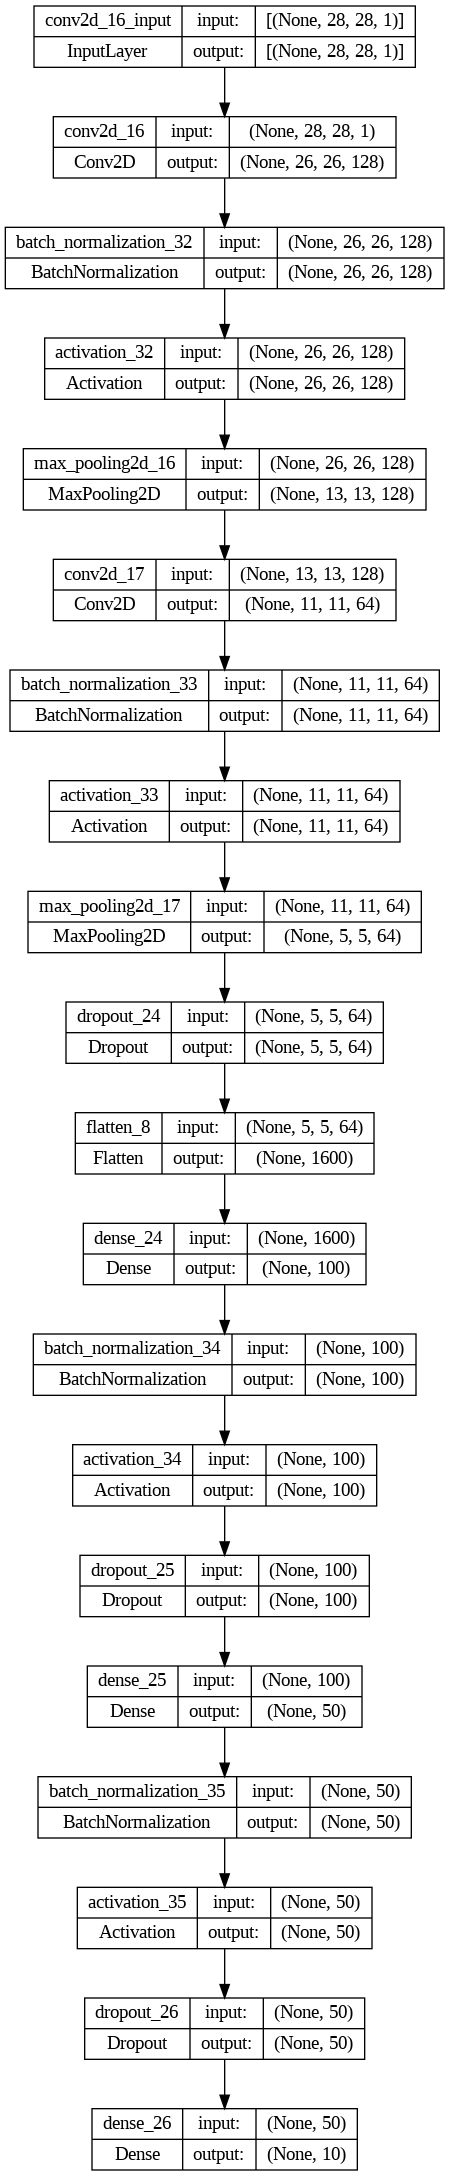

In [ ]:
plot_model(model2, show_shapes=True)

### Entrenamiento del modelo 2

In [ ]:
es2 = EarlyStopping(monitor='val_loss', patience=5,  mode='min',  verbose=1)
checkpoint2 = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo2_n2.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks=[es2, checkpoint2], epochs=150,verbose=1)

Epoch 1/150
1499/1500 [============================>.] - ETA: 0s - loss: 0.7439 - accuracy: 0.7478
Epoch 1: val_loss improved from inf to 0.38009, saving model to /content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo2_n2.h5
1500/1500 [==============================] - 16s 9ms/step - loss: 0.7437 - accuracy: 0.7479 - val_loss: 0.3801 - val_accuracy: 0.8553
Epoch 2/150
1500/1500 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8276
Epoch 2: val_loss improved from 0.38009 to 0.34525, saving model to /content/drive/MyDrive/5_semestre/Redes_neuronales_y_aprendizaje_profundo/best_model_Fashion_Mnist_modelo2_n2.h5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.5001 - accuracy: 0.8276 - val_loss: 0.3452 - val_accuracy: 0.8666
Epoch 3/150
1498/1500 [============================>.] - ETA: 0s - loss: 0.4442 - accuracy: 0.8481
Epoch 3: val_loss improved from 0.34525 to 0.33006, saving model to /content/

### Evaluación del modelo 2

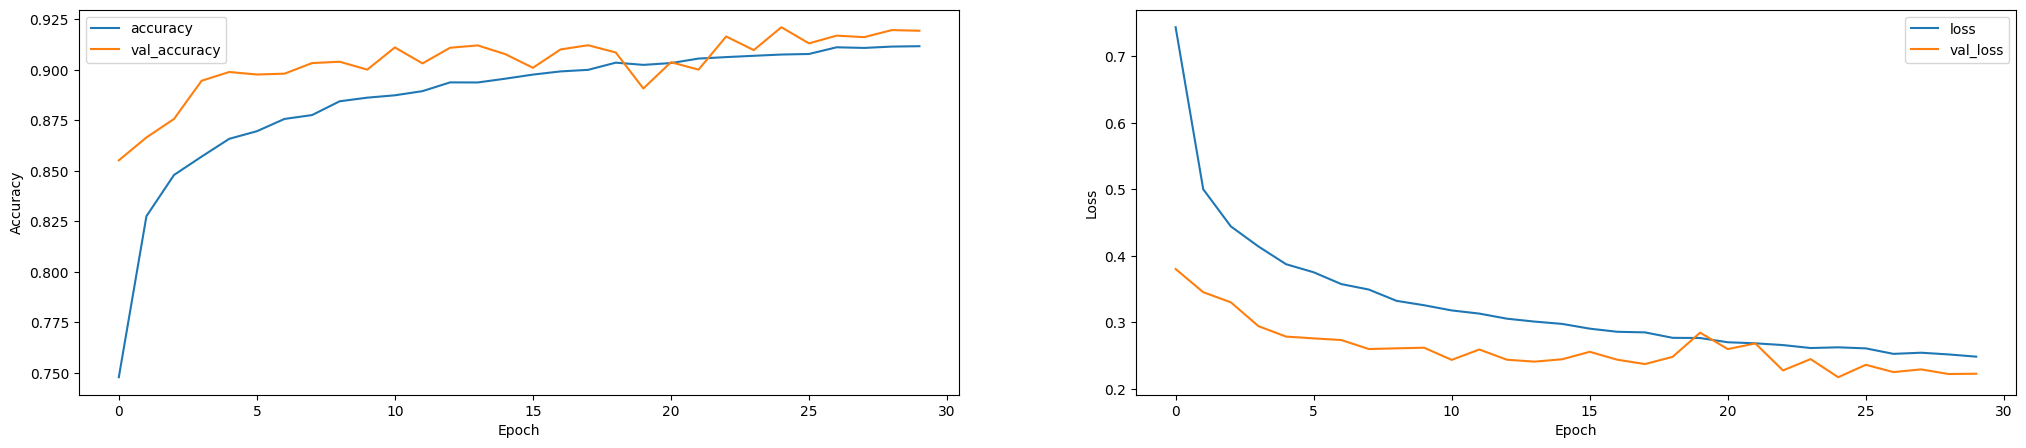

In [ ]:
fig2, axs2 = plt.subplots(1, 2,figsize=(25, 5))
axs2[0].plot(history2.history['accuracy'], label='accuracy')
axs2[0].plot(history2.history['val_accuracy'], label = 'val_accuracy')
axs2[0].set_xlabel('Epoch')
axs2[0].set_ylabel('Accuracy')
axs2[0].legend(loc='upper left')

axs2[1].plot(history2.history['loss'], label='loss')
axs2[1].plot(history2.history['val_loss'], label = 'val_loss')
axs2[1].set_xlabel('Epoch')
axs2[1].set_ylabel('Loss')
axs2[1].legend(loc='upper right')
plt.show()

In [ ]:
val_loss2, val_acc2 = model2.evaluate(X_val, y_val, verbose=0)
print(f'Validation accuracy (model 2): {val_acc2:.2f}')
print(f'Validation loss (model 2): {val_loss2:.2f}')

Validation accuracy (model 2): 0.92
Validation loss (model 2): 0.22


En la gráfica donde se presenta el acuracy, se observa que validation_accuracy esta arriba de training_accuracy, por lo que podremos decir que en validation obtenemos mayor precisión comparado al entrenamiento. El accuracy sobrepasa a 0.90, por lo cual es un buen modelo al tratarse de este tipo de dataset. Se observan algunos picos dentro de la curva debido a que en algunos momentos bajaba el accuracy durante la carga del modelo, principalmente se visualiza durante la época 18-2, sin embargo lo restauró de forma rápida.

En la gráfica de pérdida, podemos ver que estas curvas tienden a estar un poco más juntas en comparación del modelo anterior e incluso la parte de validación tiene menores pérdidas, llegando a un aproximado de solo 0.22 que es un poco menos de pérdidas en comparación del modelo 1. Aunque podríamos llegar a pensar que hay una pequeña presencia de overfitting, para un conjunto de entrenamiento en el que hay bastantes datos es algo razonable, ya que en el conjunto de prueba este modelo será más robusto


## **Comparación de los modelos**

Consideramos que el mejor modelo es el número dos por distintas razones. La principal, es debido a los resultados numéricos, pues al comparar los valores de accuracy sobre el conjunto de validación del modelo uno con el dos, el del modelo seleccionado tiene 92% en comparación del otro modelo que obtuvo 91%. Ahora bien, en el loss, sucede lo mismo, pues se pierde un 22%, mientras que en el modelo uno hay una pérdida de 25%. Además, en el modelo dos, la curva de pérdida y la de validación están más cerca, lo cual indica que se podrían llegar a ajustar de mejor forma.

Por lo mencionado anteriormente, se reitera que el modelo 2 es el que utilizaremos para evaluar nuestro conjunto de prueba, ya que en las gráficas no se aprecia la presencia de overfitting lo que indica que el modelo no se ajusta a los datos de entrenamiento y por esta razón nuestra red neuronal convolucional 2 funcionará bien frente a un conjunto de datos que no haya visto (los datos de prueba).


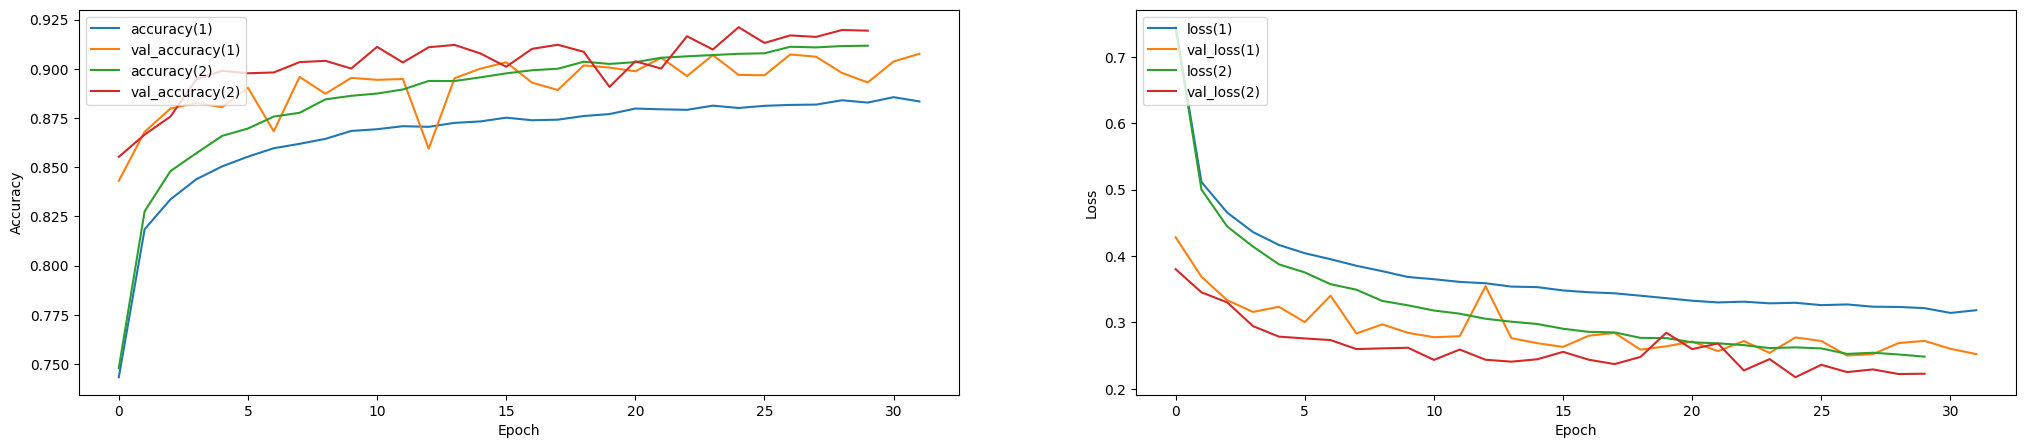

In [ ]:
figc, axsc = plt.subplots(1, 2,figsize=(25, 5))
axsc[0].plot(history.history['accuracy'], label='accuracy(1)')
axsc[0].plot(history.history['val_accuracy'], label = 'val_accuracy(1)')
axsc[0].plot(history2.history['accuracy'], label='accuracy(2)')
axsc[0].plot(history2.history['val_accuracy'], label = 'val_accuracy(2)')
axsc[0].set_xlabel('Epoch')
axsc[0].set_ylabel('Accuracy')
axsc[0].legend(loc='upper left')

axsc[1].plot(history.history['loss'], label='loss(1)')
axsc[1].plot(history.history['val_loss'], label = 'val_loss(1)')
axsc[1].plot(history2.history['loss'], label='loss(2)')
axsc[1].plot(history2.history['val_loss'], label = 'val_loss(2)')
axsc[1].set_xlabel('Epoch')
axsc[1].set_ylabel('Loss')
axsc[1].legend(loc='upper left')
plt.show()

## **Evaluación del modelo seleccionado**


In [ ]:
y_pred2 = np.argmax(model2.predict(X_test), axis=-1)
y_pred2

313/313 [==============================] - 3s 7ms/step


array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
def plot_cf_matrix(pred):
  cf_matrix = confusion_matrix(y_test, pred)
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(cf_matrix, annot=True,cbar=False,fmt='d')
  plt.xlabel("Predicted", fontsize = 18)
  plt.ylabel("True", fontsize = 18)
  plt.show()

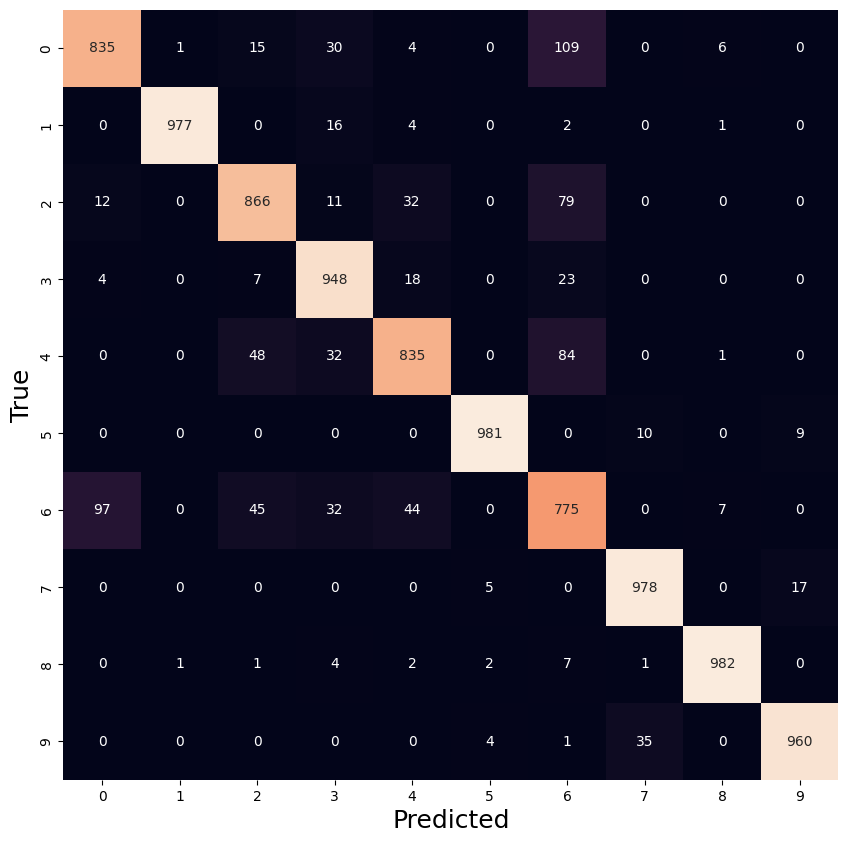

In [ ]:
plot_cf_matrix(y_pred2)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.88      0.87      0.87      1000
           3       0.88      0.95      0.91      1000
           4       0.89      0.83      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.72      0.78      0.75      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [ ]:
def plot_prediction(index, pred):
    print('Valor real: ',y_test[index])
    print('Predicción: ', pred[index])
    plt.figure(figsize=(6,3))
    plt.imshow(X_test[index], cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

label_class = pd.DataFrame(class_names, columns=['Class'])
label_class.index.name = 'Label'
label_class

,Class
Label,
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag


Valor real:  6
Predicción:  6


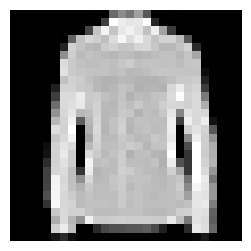

In [ ]:
i = 26
plot_prediction(i, y_pred2)

Valor real:  3
Predicción:  4


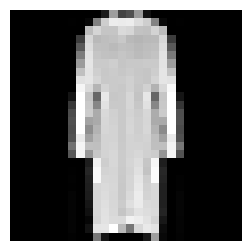

In [ ]:
i = 67
plot_prediction(i, y_pred2)

Valor real:  6
Predicción:  6


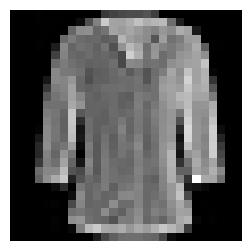

In [ ]:
i = 4
plot_prediction(i, y_pred2)

In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy (model 2): {test_acc:.2f}')
print(f'Test loss (model 2): {test_loss:.2f}')

Test accuracy (model 2): 0.91
Test loss (model 2): 0.23


## **Conclusiones**


#### Ana

Considero que la CNN seleccionada tiene un buen desempeño en nuestro conjunto de datos de prueba, aunque este se podría mejorar; ya que al evaluar nuestro modelo, este produce algunas predicciones erróneas en clases similares, en especial cuando se trata de camisas y camisetas (como se puede observar en la matriz de confusión). Esto se puede mejorar si realizamos data augmentation, pero al probar esta técnica los modelos se seguían comportando de manera similar que cuando no lo empleamos.

Dentro de las posibles mejoras que le podríamos hacer a nuestro modelo, están el uso de los regularizadores de kernel (kernel_regularizer) que aplican penalizaciones a los pesos de las capas para que la red converja de forma más rápida y evite el overfitting; a pesar de que probamos algunos modelos con regularizadores y obtuvimos buenos resultados, finalmente, no decidimos utilizarlos porque la gráfica de accuracy no se comportaba de la forma esperada, pero de utilizar bien estos regularizadores (ya sea el L1, L2 o L1L2), estos pueden ser de gran ayuda a la red neuronal.

Otra mejora que podría aumentar el desempeño de nuestro modelo es el diseñar una mejor arquitectura que resuelva el problema de clasificación de imágenes, esto sólo se puede lograr probando diferentes parámetros en las distintas capas del modelo, agregando nuevas capas y variando la tasa de aprendizaje de nuestro optimizador; pero aun con estos cambios, de acuerdo a varias investigaciones, es muy difícil diseñar una arquitectura para CNN que sobrepase el 93% de accuracy debido a la complejidad que presenta el problema. Sin embargo, conseguir un accuracy entre 92 y 93% sería un valor que podemos alcanzar con más tiempo y dedicación.


<p>&nbsp;</p>

#### Citlali

El método de clasificación y el uso de las redes neuronales se me hace algo demasiado interesante, principalmente porque se está trabajando con herramientas que todavía están en prueba, lo cual siento que a nuestro nivel de la carrera es algo que debemos de experimentar, principalmente porque en un futuro estará aún más presente.  

Al probar diversos tipos de modelos, con más capas, más funciones, pocas capas, etc. Me percaté de que hacer este tipo de pruebas puede ser realmente complejo e incluso cansado, pues al no tener una base de cómo mejorar cada modelo, necesitamos de cierta manera hacerlo al tanteo.  

Sé que podría haber posibles mejoras en los modelos. Una de las mejoras que consideramos fue hacer uso de Data Augmentation, sin embargo, al hacer las pruebas, nos percatamos de que al menos las que realizamos salieron muy similares e incluso algunas un poco males en comparación de los modelos que ya teníamos, por lo que no decidimos implementarlo como modelo de comparación. Creo que es necesario buscar un equilibrio en las capas que se desean utilizar, ya que el tener un modelo demasiado largo puede provocar resultados malos, al igual que tener un modelo muy pequeño.  

En un inicio considerábamos que aplicar Dropout no nos estaba ayudando, sin embargo, al hacer más pruebas nos percatamos de que ayuda cuando ya tienes un bloque considerable de capas, por lo que esto siento que podría ser una mejora, aplicar algunos otros bloques más de capas estructuradas. Incluso, colocar funciones de activación tipo sigmoide podría mejorar el modelo, sin embargo, no sabíamos si realmente estaba correcto usarlas, por lo que decidimos no hacerlo. Además, una propuesta que se me ocurre es tener un modelo que ya este relativamente bien e ir haciendo pruebas en este con las neuronas que se colocan, teniendo a la vez un documento para colocar con que neuronas obtenemos mejores resultados, sin embargo, es bastante tardado hacer pruebas entre un sinfín de números de neuronas.  

En conclusión, esta clase y el reto en general me ayudaron a aprender demasiadas cosas como nuevas estructuras, maneras de analizar los datos, de realizar predicciones, etc. Creo que es un ámbito en el que como estudiantes nos podríamos involucrar más para apoyar aquellas investigaciones que están en curso. En cuanto a la manera de trabajar con mi compañera, me siento bastante cómoda principalmente porque ya tenemos nuestra forma de organizarnos e incluirnos en cada proceso del proyecto. Sé que es imposible recordar todo y aprenderse todo de una manera rápida, pero sí creo que el proyecto me ayudó bastante a solucionar dudas teóricas y ahora tengo bastantes conceptos e ideas de la clasificación, las redes neuronales, convoluciones, los tipos de funciones, etc.


## **Distribución de actividades**

#### Ana

Durante el desarrollo de este proyecto, mi compañera y yo dividimos las actividades de forma equitativa. Entre las dos realizamos la introducción y diseñamos los modelos de las CNN, en la que cada quien iba probando diferentes modificaciones para ver si mejoraba el modelo; además, una vez que ya escogimos el modelo, las dos realizamos la comparación de los resultados que obtuvimos, escogimos el mejor modelo (el dos), y evaluamos el modelo. Después de eso, realice la explicación del modelo 1 y el cálculo de sus parámetros, al igual que la explicación de sus gráficas de accuracy y pérdida, y mis conclusiones sobre el proyecto. Adicionalmente, cuando estábamos diseñando los modelos, yo realice data augmentation al conjunto de entrenamiento para ver si mejoraban los accuracies de nuestros modelos, pero estos se mantenían casi igual, por lo que decidimos no utilizar data augmentation en los modelos que presentamos.


<p>&nbsp;</p>

#### Citlali

A pesar de que sí nos dividimos algunas partes, considero que la parte esencial que fue crear como tal el modelo, lo realizamos juntas. Nuestra manera de trabajar siempre ha sido conectarnos en zoom o reunirnos en el salón y esta vez no fue la excepción. En la parte de introducción, ambas colocamos nuestras ideas, lo que sabíamos y algunas cosas aprendidas en clase, en mi caso agregué un poco sobre que es la clasificación, como tienen relación con las redes neuronales convolucionales y la explicación de la base de datos. Ambas fuimos trabajando en el proyecto, sin embargo, a la hora de generar modelos, las dos probamos desde nuestros dispositivos para poder ir intercambiando ideas, por lo que al final, las explicaciones de los modelos fueron divididas y yo realicé la explicación del segundo modelo y el razonamiento de las gráficas. En la parte de los cálculos, realicé algunos y mi compañera Ana aportó con algunos otros en ambos modelos. Por mi cuenta, intente investigar algunas cosas que no entendía completamente, con el fin de apoyar un poco más dentro del modelo. Además, ambas nos preparamos juntas para la exposición y las preguntas, así para que las dos estuviéramos en sintonía.  

Lo más tardado en mi caso, fue encontrar los modelos, principalmente porque no recordaba que cambiar de entorno de ejecución me ayudaría a acelerar el proceso, por lo que mis primeros modelos me llegaron a tardar hasta 2 horas en cargar. Pero al aplicar el cambio de entorno de ejecución, esto ya fue más fácil, debido a que pude hacer muchas más pruebas en menos tiempo.